# Классификация новостей по тегам на основе текстового содержимого

**Цель:** Решение задачи многозначной многоклассовой классификации новостей на основе ключевых слов из текстового описания.

## Применение NLP для решения задачи классификации

### Подключение библиотек и загрузка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import spacy
from spacy.lang.ru.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, hamming_loss

In [2]:
tokenizer = spacy.load("ru_core_news_lg")

data = pd.read_csv("news_data.csv", encoding="utf-8")

In [3]:
sample = data.sample(n=3)

for index, new in enumerate(sample.itertuples()):
    print(f"Опубликовано: {new.Published}")
    print(f"Заголовок: {new.Title}")
    print(f"Теги: {new.Tags}")
    print(f"Просмотры: {new.Views}")
    print(f"Контент: {new.Content[:500]}...")
    
    print("\n\n")
    if len(sample) > index + 1:
        print("--------")
        print("\n\n")

Опубликовано: 2024-04-01
Заголовок: 240 человек приняли участие в Дне открытых дверей в СибГМУ
Теги: Образование
Просмотры: 519
Контент: 30 марта в СибГМУ прошел День открытых дверей для школьников, желающих познакомиться с медицинским образованием и будущими специальностями университета. Мероприятие сопровождалось финалом конкурса предпрофессиональных умений «Медскиллс», по результатам которого победители и призеры получили 10 дополнительных баллов при поступлении в СибГМУ. Мероприятия реализованы в рамках программы «МедКласс».   

	 В течение трех дней участники проходили обучение по пяти направлениям: «Врач», «Лекарства», «Ла...



--------



Опубликовано: 2024-05-31
Заголовок: В СибГМУ подвели итоги школы педагога высшего медицинского образования
Теги: Образование
Просмотры: 523
Контент: В СибГМУ завершился весенний сезон школы молодых педагогов. Участие в образовательной программе приняли более 20 сотрудников университета. На протяжение месяца под руководством экспертов участники

## EDA

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1899 entries, 0 to 1898
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Published  1899 non-null   object
 1   Title      1899 non-null   object
 2   Link       1899 non-null   object
 3   Views      1899 non-null   int64 
 4   Tags       1883 non-null   object
 5   Content    1899 non-null   object
dtypes: int64(1), object(5)
memory usage: 89.1+ KB


In [5]:
print(f"Дублей: {data.duplicated(subset=['Link']).sum()}")
print(f"Доля пропущенных целевых значений: {100 * data.loc[data['Tags'].isna(), :].shape[0] / 1888:.2f}%")

Дублей: 0
Доля пропущенных целевых значений: 0.85%


*Удалим пропуски*

In [6]:
data = data.loc[data["Tags"].notna(), :]
print(f"Осталось объектов: {data.shape[0]}")

Осталось объектов: 1883


In [7]:
data

,Published,Title,Link,Views,Tags,Content
0,2025-03-12,СибГМУ выступил соорганизатором международной ...,https://media.ssmu.ru/news/sibgmu-vystupil-soo...,69,Наука,СибГМУ уже второй раз принял участие в междуна...
1,2025-03-11,В СибГМУ подведены итоги отбора участников про...,https://media.ssmu.ru/news/v-sibgmu-zavershils...,146,Образование,Проект был запущен в 2022 году в рамках програ...
2,2025-03-10,"Сотрудник СибГМУ рассказала, как сохранить здо...",https://media.ssmu.ru/news/sotrudnik-sibgmu-ra...,223,Наука,Ассистент кафедры анатомии человека с курсом т...
3,2025-03-08,Поздравление ректора СибГМУ с Международным же...,https://media.ssmu.ru/news/pozdravlenie-rektor...,343,Университет,"Дорогие женщины, искренне поздравляю вас с Меж..."
4,2025-03-07,Юбилей празднует специалист по учебно-методиче...,https://media.ssmu.ru/news/yubiley-prazdnuet-s...,377,Университет,"Сегодня, 7 марта, день рождения отмечает специ..."
...,...,...,...,...,...,...
1894,2021-05-28,«Человек года в СибГМУ»: студент Владислав Бел...,https://media.ssmu.ru/news/chelovek-goda-v-sib...,72,"Университет, Мир СибГМУ",Одним из победителей конкурса «Человек года-20...
1895,2021-04-27,«Человек года в СибГМУ»: студентка Анастасия Р...,https://media.ssmu.ru/news/chelovek-goda-v-sib...,74,"Университет, Студенчество",Одним из победителей конкурса «Человек года-20...
1896,2021-04-13,«Человек года в СибГМУ»: Алена Шадрина о возмо...,https://media.ssmu.ru/news/chelovek-goda-v-sib...,130,"Университет, Студенчество",Одним из победителей конкурса «Человек года-20...
1897,2021-03-26,«Человек года в СибГМУ»: Екатерина Трифонова о...,https://media.ssmu.ru/news/chelovek-goda-v-sib...,86,"Университет, Студенчество",Одним из победителей конкурса «Человек года-20...


###  Анализ целевой переменной

In [8]:
data["Tags Quantity"] = data["Tags"].apply(lambda x: x.count(",")+1)
print("Распределение количества тегов в новости")
print(data["Tags Quantity"].value_counts())

Распределение количества тегов в новости
1    1689
2     177
3      15
4       2
Name: Tags Quantity, dtype: int64


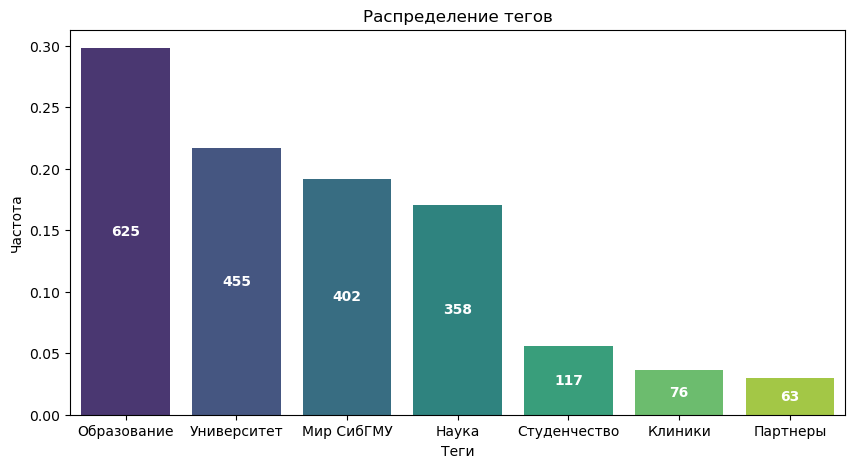

In [9]:
all_tags = [tag.strip() for tags in data["Tags"] for tag in tags.split(",")]  # Развернем теги в плоский список
tag_counts = pd.Series(all_tags).value_counts()  # Расчет частоты встречаемости каждого тега

# Гистограмма распределения тегов
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=tag_counts.index, y=tag_counts.values / sum(tag_counts.values), palette="viridis")

for i, v in enumerate(tag_counts.values / sum(tag_counts.values)):
    ax.text(i, v / 2, f"{tag_counts.values[i]}", ha='center', va='center', 
            color="white", fontsize=10, fontweight="bold")
    
plt.xlabel("Теги")
plt.ylabel("Частота")
plt.title("Распределение тегов")
plt.show()

Для оценки **дисбаланса классов** помимо визуализации используем **коэффициент вариации** - степень разброса данных относительно среднего

In [10]:
# Основные статистики
min_count = tag_counts.min()
max_count = tag_counts.max()
mean_count = tag_counts.mean()
std_dev = tag_counts.std()
cv = std_dev / mean_count  # Коэффициент вариации

print(f"Основные статистики распределения тегов:\n")
print(f"Минимальное количество вхождений: {min_count}")
print(f"Максимальное количество вхождений: {max_count}")
print(f"Среднее количество вхождений: {mean_count:.0f}")
print(f"Стандартное отклонение: {std_dev:.0f}")
print(f"Коэффициент вариации (CV): {cv:.2f} (чем выше, тем больше разброс)\n")

if cv < 0.25:
    print("Дисбаланс незначительный. Распределение тегов относительно ровное.")
elif 0.25 <= cv < 0.5:
    print("Умеренный дисбаланс. Некоторые теги встречаются заметно чаще.")
elif 0.5 <= cv < 0.75:
    print("Сильный дисбаланс! Одни теги преобладают над другими.")
else:
    print("Крайний дисбаланс! Модель может игнорировать редкие теги.")

Основные статистики распределения тегов:

Минимальное количество вхождений: 63
Максимальное количество вхождений: 625
Среднее количество вхождений: 299
Стандартное отклонение: 217
Коэффициент вариации (CV): 0.73 (чем выше, тем больше разброс)

Сильный дисбаланс! Одни теги преобладают над другими.


## Обработка данных

*Отбросим ненужные столбцы*

In [11]:
data = data.drop(columns=["Published", "Title", "Link", "Views", "Tags Quantity"])

### Приведение текста к форме, пригодной для анализа

Добавление стоп-слов в контексте медицинского университета РФ

In [12]:
additional_stop_words = set([
    "сибирский", "государственный", "медицинский", "университет",
    "томск", "томский", "сибгму", "сибгма", 
    "рф", "всероссийский", "российский",
    "куликов", "евгений", "сергеевич", 
    "образование", "спикер", "конференция", "мероприятие", "декан", "заведующий",  
    "кафедра", "факультет", "студент", "студентка", "преподаватель",  
    "ректор", "обучение", "профессор", "медицина",
    "лекция", "семинар", "практика", "доклад", "грант",
    "рассказать", "узнать", "сайт", "главное",
    "тыс", "кв", "млрд", "соответствие", "являться",
    "человек", "год", "сегодня", "впервые", "смочь"
])

stop_words = STOP_WORDS.union(additional_stop_words)
print("Слов для исключения:", len(stop_words))

Слов для исключения: 816


**Функция предобработки сырого текста**

In [13]:
def preprocess_text(text):
    """
    Возвращает:
        str: текст, приведённый к нормальной форме
    """
    
    text = re.sub(r"[-—]", " ", text)  # Заменяем тире и дефисы на пробел
    text = re.sub(r"[^А-Яа-яЁё ]", " ", text)  # Оставляем только буквы и пробелы
    text = re.sub(r"\s+", " ", text).strip().lower()  # Убираем лишние пробелы и приводим к нижнему регистру
    
    doc = tokenizer(text)
    
    tokens = [
        token.lemma_ for token in doc
        if token.lemma_ not in stop_words
        and not token.is_punct and not token.is_space and not token.like_num
        and token.ent_type_ not in {"PER", "LOC", "ORG", "DATE", "MONEY"}  # Исключаем именованные сущности
    ]
    
    return " ".join(tokens)

In [14]:
tqdm.pandas()
data["Clean Content"] = data["Content"].progress_apply(preprocess_text)
data

100%|██████████████████████████████████████████████████████████████████████████████| 1883/1883 [04:37<00:00,  6.78it/s]


,Tags,Content,Clean Content
0,Наука,СибГМУ уже второй раз принял участие в междуна...,раз принять участие международный олимпиада по...
1,Образование,Проект был запущен в 2022 году в рамках програ...,проект запустить рамка программа приоритет цел...
2,Наука,Ассистент кафедры анатомии человека с курсом т...,ассистент анатомия курс топографический анатом...
3,Университет,"Дорогие женщины, искренне поздравляю вас с Меж...",дорогой женщина искренне поздравлять междунаро...
4,Университет,"Сегодня, 7 марта, день рождения отмечает специ...",март день рождение отмечать специалист учебно ...
...,...,...,...
1894,"Университет, Мир СибГМУ",Одним из победителей конкурса «Человек года-20...,победитель конкурс номинация волонтёрский деят...
1895,"Университет, Студенчество",Одним из победителей конкурса «Человек года-20...,победитель конкурс номинация студенчество курс...
1896,"Университет, Студенчество",Одним из победителей конкурса «Человек года-20...,победитель конкурс номинация студенчество курс...
1897,"Университет, Студенчество",Одним из победителей конкурса «Человек года-20...,победитель конкурс номинация студенчество курс...


In [15]:
data = data[["Clean Content", "Tags"]]

## Классификация новостей по тегам

In [16]:
data = data.copy()
data["Tags"] = data["Tags"].apply(lambda x: x.split(", "))
data

,Clean Content,Tags
0,раз принять участие международный олимпиада по...,[Наука]
1,проект запустить рамка программа приоритет цел...,[Образование]
2,ассистент анатомия курс топографический анатом...,[Наука]
3,дорогой женщина искренне поздравлять междунаро...,[Университет]
4,март день рождение отмечать специалист учебно ...,[Университет]
...,...,...
1894,победитель конкурс номинация волонтёрский деят...,"[Университет, Мир СибГМУ]"
1895,победитель конкурс номинация студенчество курс...,"[Университет, Студенчество]"
1896,победитель конкурс номинация студенчество курс...,"[Университет, Студенчество]"
1897,победитель конкурс номинация студенчество курс...,"[Университет, Студенчество]"


`MultiLabelBinarizer()` преобразует списки тегов (multi-label) в бинарную матрицу, где:  
- `1` означает, что тег присутствует в новости.  
- `0` означает, что тег отсутствует.  

In [17]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data["Tags"])

print(f"Закодированные теги: {', '.join(mlb.classes_)}")
print("Примеры кодирования тегов:", y[:5], "-" * (len(mlb.classes_)*2 + 4), y[-5:], sep="\n")

Закодированные теги: Клиники, Мир СибГМУ, Наука, Образование, Партнеры, Студенчество, Университет
Примеры кодирования тегов:
[[0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]]
------------------
[[0 1 0 0 0 0 1]
 [0 0 0 0 0 1 1]
 [0 0 0 0 0 1 1]
 [0 0 0 0 0 1 1]
 [0 0 0 0 0 0 1]]


### Разбиение набора данных на train и test

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data["Clean Content"], y, test_size=0.25, random_state=42)

### Кодирование слов &mdash; TF&ndash;IDF преобразование

**TF-IDF** (Term Frequency - Inverse Document Frequency) преобразование — преобразование документов в числовые признаки, отражающие **значимость** слов в **контексте документа**. Полученная разреженная матрица (`csr_matrix`) экономит память, так как хранит только ненулевые значения, поскольку большинство слов не встречаются в каждом тексте. Формула вычисления **TF-IDF** для слова `t` в документе `d` выглядит так:

$$\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \log \frac{N}{\text{DF}(t)}$$

где:  
- **TF** — частота слова в документе.  
- **DF** — количество документов, содержащих это слово.  
- **N** — общее число документов в корпусе.  

In [19]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # Используем униграммы (отдельные слова) и биграммы (пары слов)
    min_df=0.05,  # Слова, встречающиеся в менее чем 5% документов, удаляются
    max_df=0.95,  # Слова, встречающиеся в более чем 95% документов, удаляются
    norm=None  # Отключаем L2-регуляризацию
)

# Обучаем векторизатор на обучающем наборе и трансформируем оба набора
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Целевая переменная (если Tags — строка с метками, возможно, нужно бинаризовать или кодировать)
y_train = y_train
y_test = y_test

# Выводим размеры полученных наборов
print(f"Размер обучающего набора: {X_train.shape}")
print(f"Размер тестового набора: {X_test.shape}")
print(f"Оставлено слов и пар слов в TF-IDF: {X_train.shape[1]}")

Размер обучающего набора: (1412, 513)
Размер тестового набора: (471, 513)
Оставлено слов и пар слов в TF-IDF: 513


### Обучение модели логистической регрессии

`OneVsRestClassifier()` разбивает многоклассовую задачу на несколько бинарных, создавая отдельный классификатор для каждого класса

In [20]:
clf = OneVsRestClassifier(LogisticRegression(C=0.001,  # Усиливаем L2 регуляризацию
                                             class_weight="balanced", 
                                             max_iter=1000,  
                                             random_state=42))

print("Обучение модели...")
clf.fit(X_train, y_train)
print("Обучение завершено.")

Обучение модели...
Обучение завершено.


### Оценка качества 

Помимо классических метрик классификации, таких как **precision**, **recall** и **F1-score**, мы также используем **`Hamming Loss`**. Эта метрика показывает **долю неверно предсказанных  меток** по всем объектам и позволяет оценить, насколько точно модель классифицирует многоклассовые данные.

In [21]:
def evaluate_model(y_true, y_pred):
    print(classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0))
    
    hl = hamming_loss(y_true, y_pred)
    print(f"Hamming Loss: {hl:.3f}")
    
    non_empty_preds = sum(1 for x in y_pred if sum(x) == 0)
    preds_len = len(y_pred)
    fraction = 100 * non_empty_preds / preds_len
    print(f"Объектов без предсказанных тегов: {non_empty_preds} из {preds_len}, что составляет {fraction:.2f}%")

In [22]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("Оценка на обучающей выборке".center(60, "-"))
evaluate_model(y_train, y_pred_train)

print("\n", "#"*55, "\n")

print("Оценка на тестовой выборке".center(60, "-"))
evaluate_model(y_test, y_pred_test)

----------------Оценка на обучающей выборке-----------------
              precision    recall  f1-score   support

     Клиники       0.61      0.98      0.75        60
  Мир СибГМУ       0.59      0.90      0.72       308
       Наука       0.71      0.90      0.79       261
 Образование       0.76      0.87      0.81       458
    Партнеры       0.56      0.98      0.71        46
Студенчество       0.48      0.99      0.65        82
 Университет       0.60      0.85      0.70       342

   micro avg       0.64      0.89      0.75      1557
   macro avg       0.62      0.92      0.73      1557
weighted avg       0.66      0.89      0.75      1557
 samples avg       0.70      0.89      0.76      1557

Hamming Loss: 0.095
Объектов без предсказанных тегов: 23 из 1412, что составляет 1.63%

 ####################################################### 

-----------------Оценка на тестовой выборке-----------------
              precision    recall  f1-score   support

     Клиники       0.33  

### Оптимизация предсказаний

#### Оценка влияния порога вероятности (threshold) на качество модели:

1. Анализ того, как изменение `threshold` влияет на **Hamming Loss** и **количество пустых предсказаний**.
2. Определение **оптимального порога**, при котором балансируются ошибки модели.
3. Визуализация зависимостей, чтобы наглядно увидеть, как выбор `threshold` изменяет качество предсказаний модели.

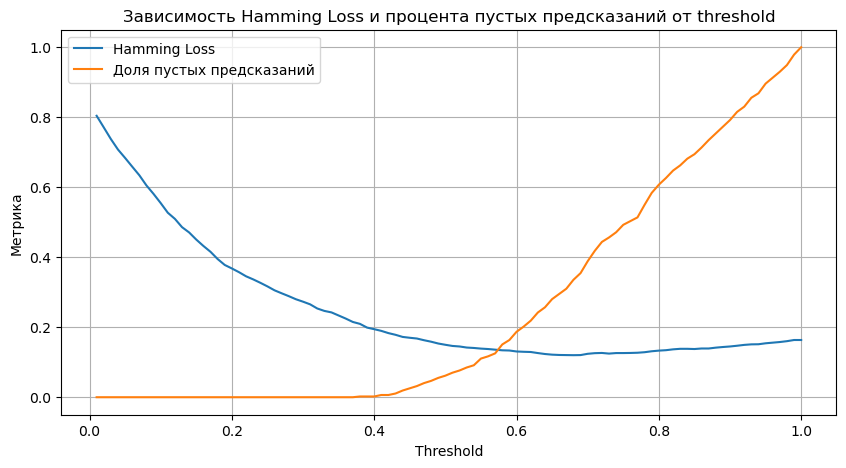

In [23]:
# Диапазон значений threshold
thresholds = np.arange(0.01, 1.01, 0.01)

# Хранение результатов
hamming_losses = []
empty_fraction = []

for threshold in thresholds:
    y_pred2 = clf.predict_proba(X_test)
    y_pred2 = [[int(probability >= threshold) for probability in probabilities] for probabilities in y_pred2]

    hl = hamming_loss(y_test, y_pred2)
    hamming_losses.append(hl)
    
    non_empty_preds = sum(1 for x in y_pred2 if sum(x) == 0)
    preds_len = len(y_pred2)
    fraction = non_empty_preds / preds_len
    empty_fraction.append(fraction)

# Построение графиков
plt.figure(figsize=(10, 5))
plt.plot(thresholds, hamming_losses, label="Hamming Loss")
plt.plot(thresholds, empty_fraction, label="Доля пустых предсказаний")
plt.xlabel("Threshold")
plt.ylabel("Метрика")
plt.title("Зависимость Hamming Loss и процента пустых предсказаний от threshold")
plt.legend()
plt.grid(True)

plt.show()

- **Если нужны только релевантные теги** → Увеличьте `threshold` (оптимизируем **Precision** и **Hamming Loss**).
- **Если важно найти все возможные теги** → Уменьшите `threshold` (оптимизируем **Recall** и **Долю пустых предсказаний**).

In [24]:
threshold = 0.58  # Отобразим полный отчёт по метрикам для порога, на котором пересеклись зависимости
y_pred2 = clf.predict_proba(X_test)
y_pred2 = [[int(probability >= threshold) for probability in probabilities] for probabilities in y_pred2]
evaluate_model(y_test, y_pred2)

              precision    recall  f1-score   support

     Клиники       0.38      0.69      0.49        16
  Мир СибГМУ       0.63      0.63      0.63        94
       Наука       0.69      0.71      0.70        97
 Образование       0.74      0.63      0.68       167
    Партнеры       0.35      0.41      0.38        17
Студенчество       0.31      0.43      0.36        35
 Университет       0.49      0.44      0.46       113

   micro avg       0.59      0.59      0.59       539
   macro avg       0.51      0.56      0.53       539
weighted avg       0.61      0.59      0.59       539
 samples avg       0.54      0.60      0.55       539

Hamming Loss: 0.134
Объектов без предсказанных тегов: 71 из 471, что составляет 15.07%


### Интерпретация результатов

Выделим **Топ-50 ключевых слов/пар слов** для каждого тега в порядке их убывания по **степени важности**

In [25]:
coef_df = pd.DataFrame(
    np.vstack([est.coef_ for est in clf.estimators_]),  # Собираем коэффициенты всех логистических регрессий
    index=mlb.classes_,  # Метки классов
    columns=vectorizer.get_feature_names_out()  # Названия признаков (слов)
)

top_features_df = pd.DataFrame({
    "Топ-50 значимых cлов/пар слов для тега": coef_df.apply(lambda x: ", ".join(x.nlargest(50).index), axis=1)
})


# Установим максимальную высоту ячеек для отображения полного списка признаков
pd.options.display.max_colwidth = None

top_features_df

,Топ-50 значимых cлов/пар слов для тега
Клиники,"клиника, врач, операция, эксперт, случай, отделение, уровень, заболевание, время, образ, пациент, важный, диагностика, помощь, совет, обеспечивать, номинация, лечение, влияние, апрель, состояние, компания, образовательный лаборатория, выполнение, патология, повышение, ребёнок, рекомендация, помогать, победитель, отмечать, выявление, ранний, ход, дополнительный, взаимодействие, существовать, число, хороший, орган, кандидат наука, уникальный, должность, доступный, партнёр, оборудование, здоровый, использовать, связь, современный"
Мир СибГМУ,"спортивный, поздравление, время, команда, совет, пройти, сотрудник, заниматься, анатомия, день, защитить, момент, отечественный, спорт, информационный, творческий, окончить, председатель, участник, слушатель, семья, победитель, конкурс, медик, начало, событие, страна, категория, детский, друг, второй, институт, возможный, академический, будущий, экскурсия, заместитель, раз, отделение, проводить, посвятить, площадка, рабочий, член, путь, молодёжный политика, следующий, посетить, проект, степень"
Наука,"учёный, научный, выступить, молодой учёный, научно, молодой, проект, наука, организатор, представить, практический, заболевание, аспирант, аспирантура, участие, исследование, оборудование, метод, ознакомиться, педиатрия курс, технологический, физический, открытие, фармация, современный, разработка, анализ, перспектива, молекулярный, руководитель, позволять, формат, реализоваться, исследователь, посетить, возраст, наука доцент, ассистент, применение, случай, выявление, лабораторный, связать, средство, клетка, отбор, основа, активность, использование, технология"
Образование,"образовательный, курс, онлайн, абитуриент, диплом, документ, школьник, олимпиада, знание, учебный, навык, подготовка, выпускник, подать, современный, педагогический, хирургия, профессиональный, дисциплина, специальность, успешный, программа приоритет, задача, почта, образовательный программа, открытый, март, окончание, зарегистрироваться, технология, включать, изучать, успешно, профессия, ординатор, программа, лечебный дело, здоровье, будущий, проходить, этап, исследователь, модель, занять, производство, квалификация, вопрос, дополнительный, повышение квалификация, пациент"
Партнеры,"сотрудничество, особый, совместный, ребёнок, цифровой, компания, поддержка, подготовка, готовый, ординатор, научно исследовательский, посетить, центр, внедрение, условие, реализоваться, учреждение, врач, кадр, организация, здравоохранение, отметить, рамка, встреча, рабочий, оборудование, взаимодействие, применение, отрасль, технологический, мастер, профилактика, модель, совместно, ход, современный, врачебный, опыт, специалист, желать, ежегодно, комплекс, важный, исследовательский, сообщество, помощь, регион, клиника, обсудить, занятие"
Студенчество,"студенческий, молодёжный, медик, форум, проект, педиатрия, направить, навык, проведение, участник, лицо, выявление, принять участие, спортивный, команда, творческий, интересный, принять, занять, событие, развиваться, председатель, рекомендация, большой, время, руководитель, первый, компания, сложный, учиться, выбор, достижение, деятельность, отмечать, информация, март, период, регистрация, жизнь, сессия, второй, вопрос, итог, готовый, победитель конкурс, общество, выбрать, идея, директор, помощь"
Университет,"администрация, деятельность, выступление, вклад, должность, сфера, разработка, окончить, автор, вуз, обеспечение, поздравление, сформировать, работать, диссертация, руководитель, коммуникация, мировой, активно, комиссия, позиция, наградить, кабинет, наука, история, возможность, проектный, преподавательский, отношение, старший, полный, очный, отмечать, номинация, интерес, уникальный, идея, диагностика, войти, ситуация, инициатива, стратегический, развиваться, сессия, хороший, город, фото, проректор, группа, доступный"


#### Отобразим:

- Слова/Пары слов, встречающиеся в нескольких тегах
- Слова/Пары слов, встречающиеся только в одном теге

In [26]:
word_to_tags = {}  # Словарь {слово: [список тегов]}

for tag, words in top_features_df["Топ-50 значимых cлов/пар слов для тега"].items():
    for word in words.split(", "):
        if word not in word_to_tags:
            word_to_tags[word] = []
        word_to_tags[word].append(tag)  # Добавляем тег, в котором встретилось слово

repeated_words = {word: ", ".join(tags) for word, tags in word_to_tags.items() if len(tags) > 1}


unique_words_by_tag = {}

for word, tags in word_to_tags.items():
    if len(tags) == 1:
        tag = tags[0]
        if tag not in unique_words_by_tag:
            unique_words_by_tag[tag] = []
        unique_words_by_tag[tag].append(word)

In [27]:
repeated_words_df = pd.DataFrame(list(repeated_words.items()), columns=["Слово", "Теги"])
repeated_words_df["Количество тегов"] = repeated_words_df["Теги"].apply(lambda x: x.count(",") + 1)
repeated_words_df = repeated_words_df.sort_values(by="Количество тегов", ascending=False).\
drop(columns=["Количество тегов"])

repeated_words_df

,Слово,Теги
26,современный,"Клиники, Наука, Образование, Партнеры"
17,выявление,"Клиники, Наука, Студенчество"
40,проект,"Мир СибГМУ, Наука, Студенчество"
16,отмечать,"Клиники, Студенчество, Университет"
44,руководитель,"Наука, Студенчество, Университет"
...,...,...
28,поздравление,"Мир СибГМУ, Университет"
29,команда,"Мир СибГМУ, Студенчество"
1,врач,"Клиники, Партнеры"
31,окончить,"Мир СибГМУ, Университет"


In [28]:
unique_words_df = pd.DataFrame(
    [(tag, ", ".join(words)) for tag, words in unique_words_by_tag.items()],
    columns=["Тег", "Слова"]
)
unique_words_df

,Тег,Слова
0,Клиники,"операция, эксперт, уровень, образ, обеспечивать, лечение, влияние, апрель, состояние, образовательный лаборатория, выполнение, патология, повышение, помогать, ранний, существовать, число, орган, кандидат наука, партнёр, здоровый, использовать, связь"
1,Мир СибГМУ,"пройти, сотрудник, заниматься, анатомия, день, защитить, момент, отечественный, спорт, информационный, слушатель, семья, конкурс, начало, страна, категория, детский, друг, институт, возможный, академический, экскурсия, заместитель, раз, проводить, посвятить, площадка, член, путь, молодёжный политика, следующий, степень"
2,Наука,"учёный, научный, выступить, молодой учёный, научно, молодой, организатор, представить, практический, аспирант, аспирантура, участие, исследование, метод, ознакомиться, педиатрия курс, физический, открытие, фармация, анализ, перспектива, молекулярный, позволять, формат, возраст, наука доцент, ассистент, лабораторный, связать, средство, клетка, отбор, основа, активность, использование"
3,Образование,"образовательный, курс, онлайн, абитуриент, диплом, документ, школьник, олимпиада, знание, учебный, выпускник, подать, педагогический, хирургия, профессиональный, дисциплина, специальность, успешный, программа приоритет, задача, почта, образовательный программа, открытый, окончание, зарегистрироваться, включать, изучать, успешно, профессия, программа, лечебный дело, здоровье, проходить, этап, производство, квалификация, повышение квалификация"
4,Партнеры,"сотрудничество, особый, совместный, цифровой, поддержка, научно исследовательский, центр, внедрение, условие, учреждение, кадр, организация, здравоохранение, отметить, рамка, встреча, отрасль, мастер, профилактика, совместно, врачебный, опыт, специалист, желать, ежегодно, комплекс, исследовательский, сообщество, регион, обсудить, занятие"
5,Студенчество,"студенческий, молодёжный, форум, педиатрия, направить, проведение, лицо, принять участие, интересный, принять, большой, первый, сложный, учиться, выбор, достижение, информация, период, регистрация, жизнь, итог, победитель конкурс, общество, выбрать, директор"
6,Университет,"администрация, выступление, вклад, сфера, автор, вуз, обеспечение, сформировать, работать, диссертация, коммуникация, мировой, активно, комиссия, позиция, наградить, кабинет, история, возможность, проектный, преподавательский, отношение, старший, полный, очный, интерес, войти, ситуация, инициатива, стратегический, город, фото, проректор, группа"


### 📰 Вывод

#### Ход работы
Собрали и обработали текстовые данные, построили TF-IDF представление, после чего обучили логистическую регрессию для многозначной классификации.

#### Результаты
Модель показывает уверенное качество классификации: хорошо выделяет значимые признаки для тегов и предсказывает их с достаточной точностью. Средние метрики сбалансированы, но точность предсказаний варьируется для разных тегов. В целом модель уверенно справляется с задачей, хотя в некоторых случаях может либо пропускать теги, либо ошибочно их назначать.

#### Топ-50 значимых слов
Выведены ключевые слова и пары слов, наиболее влияющие на предсказание тегов.
